In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
def transform_cleb_df_into_wal_df(cleb_df):
    
    index_names = {}
    for i, (_, row) in enumerate(cleb_df.iterrows()):
        
        year = str(int(row[2]))
        month = str(int(row[1]))
        day = str(int(row[0]))
        hour = str(int(row[3]))
        index_name = year+'-'+month+'-'+day+'-'+hour
        
        index_names[i] = index_name
        
    
    cleb_df.rename(index=index_names)
    cleb_df = cleb_df.drop('day', 1)
    cleb_df = cleb_df.drop('month', 1)
    cleb_df = cleb_df.drop('year', 1)
    cleb_df = cleb_df.drop('hour', 1)
    return cleb_df.replace(-1, np.nan)





flow_path = "/home/colombelli/Documents/hydro-ml/data/Vazao.txt"
rain_path = "/home/colombelli/Documents/hydro-ml/data/Chuva.txt"
et_path = "/home/colombelli/Documents/hydro-ml/data/ET.txt"

flow_df = pd.read_csv(flow_path, sep="\t", header=None)
flow_df.columns = ["day", "month", "year", "hour", "flow"]

rain_df = pd.read_csv(rain_path, sep="\t", header=None)
rain_df.columns = ["day", "month", "year", "hour", "rain"]

et_df = pd.read_csv(et_path, sep="\t", header=None)
et_df.columns = ["day", "month", "year", "hour", "et"]


flow_df = transform_cleb_df_into_wal_df(flow_df)
rain_df = transform_cleb_df_into_wal_df(rain_df)
et_df = transform_cleb_df_into_wal_df(et_df)

In [28]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
            
        flow_et = sequences[i:end_ix, 0:2]
        future_rain = sequences[end_ix:out_end_ix, 2:3]
        future_flow = sequences[end_ix:out_end_ix, 0]
        
        seq_x = np.concatenate((flow_et, future_rain), axis=1)
        seq_y = future_flow
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [29]:
def get_nash(observed, modeled):
    
    mean_obs = np.mean(observed)
    
    variance = 0 
    squared_err = 0
    for t, obs_flow in enumerate(observed):
        squared_err += (modeled[t] - obs_flow) ** 2
        variance += (obs_flow - mean_obs) ** 2
        
    nash = 1 - (squared_err  / variance)
    return nash

In [30]:
dataset = pd.concat([flow_df, et_df,rain_df], axis=1)
dataset.columns = ['flow', 'et', 'rain']

n_steps_in = 24
n_steps_out = 24

to_split = np.array(dataset.iloc[6078:17486, ])   # get 14086 to 17486 for testing
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [31]:
model = Sequential()
model.add(LSTM(512, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [32]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
356/356 [==============================] - 45s 126ms/step - loss: 259837.5625
Epoch 2/200
356/356 [==============================] - 45s 126ms/step - loss: 200812.5156
Epoch 3/200
356/356 [==============================] - 46s 129ms/step - loss: 163557.8125
Epoch 4/200
356/356 [==============================] - 45s 127ms/step - loss: 137726.6094
Epoch 5/200
356/356 [==============================] - 45s 126ms/step - loss: 118382.6250
Epoch 6/200
356/356 [==============================] - 45s 126ms/step - loss: 102156.5625
Epoch 7/200
356/356 [==============================] - 45s 126ms/step - loss: 88382.4766
Epoch 8/200
356/356 [==============================] - 45s 127ms/step - loss: 76755.3203
Epoch 9/200
356/356 [==============================] - 45s 127ms/step - loss: 66911.1719
Epoch 10/200
356/356 [==============================] - 45s 127ms/step - loss: 58753.0312
Epoch 11/200
356/356 [==============================] - 45s 128ms/step - loss: 51827.7422
Epoch 12/200


356/356 [==============================] - 45s 126ms/step - loss: 9637.1621
Epoch 93/200
356/356 [==============================] - 45s 125ms/step - loss: 8676.3438
Epoch 94/200
356/356 [==============================] - 46s 128ms/step - loss: 8518.1006
Epoch 95/200
356/356 [==============================] - 45s 127ms/step - loss: 9326.1582
Epoch 96/200
356/356 [==============================] - 45s 127ms/step - loss: 8451.1084
Epoch 97/200
356/356 [==============================] - 45s 126ms/step - loss: 8227.8398
Epoch 98/200
356/356 [==============================] - 45s 127ms/step - loss: 8839.9912
Epoch 99/200
356/356 [==============================] - 45s 127ms/step - loss: 7744.8477
Epoch 100/200
356/356 [==============================] - 45s 127ms/step - loss: 9048.1572
Epoch 101/200
356/356 [==============================] - 45s 127ms/step - loss: 9067.8516
Epoch 102/200
356/356 [==============================] - 45s 127ms/step - loss: 9876.6533
Epoch 103/200
356/356 [========

356/356 [==============================] - 45s 126ms/step - loss: 6883.0146
Epoch 184/200
356/356 [==============================] - 46s 128ms/step - loss: 7098.5083
Epoch 185/200
356/356 [==============================] - 45s 127ms/step - loss: 7278.5972
Epoch 186/200
356/356 [==============================] - 46s 129ms/step - loss: 6828.8667
Epoch 187/200
356/356 [==============================] - 47s 133ms/step - loss: 6838.9404
Epoch 188/200
356/356 [==============================] - 47s 133ms/step - loss: 7105.0386
Epoch 189/200
356/356 [==============================] - 46s 130ms/step - loss: 9076.1045
Epoch 190/200
356/356 [==============================] - 46s 129ms/step - loss: 7896.8159
Epoch 191/200
356/356 [==============================] - 46s 128ms/step - loss: 7746.0806
Epoch 192/200
356/356 [==============================] - 46s 128ms/step - loss: 7232.3154
Epoch 193/200
356/356 [==============================] - 47s 132ms/step - loss: 7309.6523
Epoch 194/200
356/356 [=

KeyboardInterrupt: 

In [44]:
to_split = np.array(dataset.iloc[14478:17486, ])
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

observations = []
predictions = []

test_len = len(X)
for i in tqdm(range(test_len)):
    
    x = X[i].reshape((1, n_steps_in, n_features))
    predicted = model.predict(x, verbose=0).flatten()
    observed = y[i]
    
    observations.append(observed)
    predictions.append(predicted)

100%|██████████| 2961/2961 [01:24<00:00, 35.03it/s]


In [45]:
def plot_nash_hor(horizon, observations, predictions):
    
    hor_pred = []
    for pred in predictions:
        hor_pred.append(pred[horizon-1])

    hor_obs = []
    for obs in observations:
        hor_obs.append(obs[horizon-1])
        
    nash = get_nash(hor_obs, hor_pred)
    plt.plot(hor_obs, label="obs")
    plt.plot(hor_pred, label="pred")
    plt.legend(loc="upper left")
    plt.title('Forecasting horizon: '+str(horizon)+' hours (NSE: ' + f'{nash:.5f}' + ')')
    plt.show()
    return

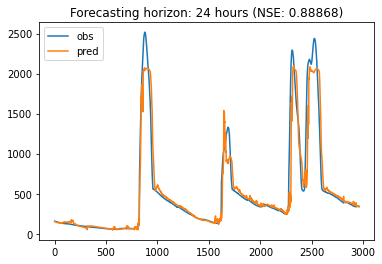

In [47]:
plot_nash_hor(24,  observations, predictions)

In [40]:
model_json = model.to_json()
with open("poc2.json", "w") as json_file:
    json_file.write(model_json)
    
    
# serialize weights to HDF5
model.save_weights("poc2.h5")

In [42]:
dataset = pd.concat([flow_df, et_df,rain_df], axis=1)
dataset.columns = ['flow', 'et', 'rain']

n_steps_in = 24
n_steps_out = 24

to_split = np.array(dataset.iloc[6078:17486, ])   # get 14086 to 17486 for testing
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [43]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
356/356 [==============================] - 46s 128ms/step - loss: 9101.9561
Epoch 2/200
356/356 [==============================] - 46s 128ms/step - loss: 9679.5674
Epoch 3/200
356/356 [==============================] - 46s 128ms/step - loss: 8721.3447
Epoch 4/200
356/356 [==============================] - 46s 129ms/step - loss: 7622.4648
Epoch 5/200
356/356 [==============================] - 45s 127ms/step - loss: 7909.9683
Epoch 6/200
356/356 [==============================] - 45s 127ms/step - loss: 7176.2021
Epoch 7/200
356/356 [==============================] - 45s 127ms/step - loss: 7321.7407
Epoch 8/200
356/356 [==============================] - 46s 128ms/step - loss: 7229.8770
Epoch 9/200
356/356 [==============================] - 46s 128ms/step - loss: 7269.9707
Epoch 10/200
356/356 [==============================] - 45s 127ms/step - loss: 6743.5796
Epoch 11/200
356/356 [==============================] - 45s 126ms/step - loss: 6741.2227
Epoch 12/200
356/356 [========

356/356 [==============================] - 45s 128ms/step - loss: 7646.5566
Epoch 94/200
356/356 [==============================] - 46s 128ms/step - loss: 8679.3945
Epoch 95/200
356/356 [==============================] - 45s 128ms/step - loss: 8051.0415
Epoch 96/200
356/356 [==============================] - 45s 127ms/step - loss: 7162.6362
Epoch 97/200
356/356 [==============================] - 46s 128ms/step - loss: 7288.8794
Epoch 98/200
356/356 [==============================] - 45s 127ms/step - loss: 7081.6772
Epoch 99/200
356/356 [==============================] - 45s 128ms/step - loss: 7200.6357
Epoch 100/200
356/356 [==============================] - 46s 128ms/step - loss: 7722.0068
Epoch 101/200
356/356 [==============================] - 45s 128ms/step - loss: 7497.5811
Epoch 102/200
356/356 [==============================] - 46s 129ms/step - loss: 7171.8271
Epoch 103/200
356/356 [==============================] - 46s 128ms/step - loss: 7158.8242
Epoch 104/200
356/356 [=======

KeyboardInterrupt: 